In [103]:
import numpy as np
import glob
import cv2
import torch
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from torchvision.models import vgg16

np.random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [104]:
# Load data: function from jascha
n_samples = 100

def load_images(n_samples, path):
    filelist = glob.glob(path)
    if n_samples < len(filelist):
        filelist = np.random.choice(filelist, n_samples)
    return np.array([cv2.imread(fname) for fname in filelist])


apple_healty = (load_images(n_samples, "Plant_leave_diseases_dataset_without_augmentation/Apple___healthy/*.JPG") / 255 ).astype(np.float32)
apple_black_rot = (load_images(n_samples, "Plant_leave_diseases_dataset_without_augmentation/Apple___Black_rot/*.JPG") / 255 ).astype(np.float32)

print(apple_healty.shape)
print(apple_black_rot.shape)

(100, 256, 256, 3)
(100, 256, 256, 3)


In [116]:
# Form dataloaders
image_data = np.concatenate((apple_healty, apple_black_rot)).astype(np.float32)
image_data = np.transpose(image_data, (0,3,1,2))
label_data = np.concatenate((np.zeros(apple_healty.shape[0]), np.ones(apple_black_rot.shape[0]))).astype(int)

image_data = torch.from_numpy(image_data)
label_data = torch.from_numpy(label_data)

# Split the transformed data into training and testing sets
train_data, test_data, train_labels, test_labels = train_test_split(
    image_data, label_data, test_size=0.2, random_state=42)

def normalise(data):
    return (data - torch.mean(data, dim=(0, 1, 2))) / torch.std(data, dim=(0, 1, 2))

train_mean, train_std = torch.mean(train_data, dim=(0, 1, 2)), torch.std(train_data, dim=(0, 1, 2)) # save for visualiations

train_data = normalise(train_data)
test_data = normalise(test_data)

# Create Tensor datasets
train_dataset = TensorDataset(train_data, train_labels)
test_dataset = TensorDataset(test_data, test_labels)

# Set batch size for dataloaders
batch_size = 64

# Create train and test data loaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

images, labels = next(iter(train_dataloader))
print(images.shape)
print(labels.shape)

torch.Size([64, 3, 256, 256])
torch.Size([64])


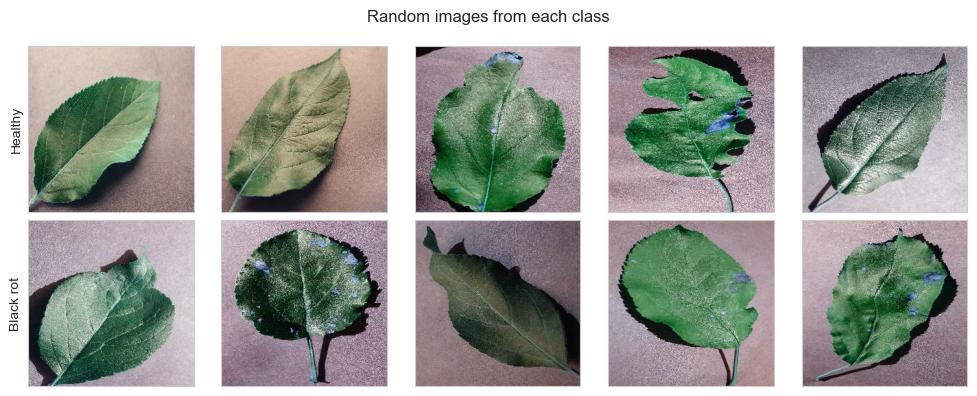

In [113]:
# Visualise images
def unnormalise(img, mean, std):
    return img * std + mean

imgs = unnormalise(train_data, train_mean, train_std)
imgs = np.transpose(imgs, (0, 2, 3, 1))
imgs = np.clip(imgs, 0, 1) # clip because of the computation error for 0 values


n_images = 5
fig, axs = plt.subplots(2, n_images, figsize=(10,4))
axs = axs.flatten()
for cl in range(2):
    label = np.where(labels == cl)[0]
    idxs = np.random.choice(label, n_images, replace=False)
    axs[cl*n_images].set_ylabel(["Healthy", "Black rot"][cl])

    for i, idx in enumerate(idxs): #axs.flatten()
        axs[i+cl*n_images].imshow(imgs[idx])
        #axs[i+cl*n_images].axis('off')
        axs[i+cl*n_images].set_xticks([])
        axs[i+cl*n_images].set_yticks([])
plt.suptitle("Random images from each class")
plt.tight_layout()

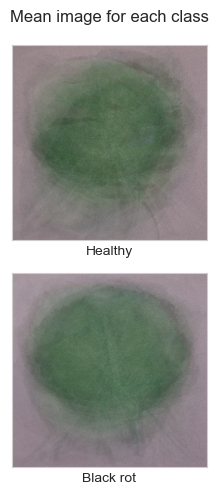

In [114]:
# Visualise mean images

fig, axs = plt.subplots(2,1,figsize=(10, 5))
for cl, ax in zip(range(2), axs.flatten()): #axs.flatten()
    label = np.where(labels == cl)
    ax.imshow(torch.mean(imgs[label], dim=0)) #, ax.axis('off')
    ax.set(xlabel = ["Healthy", "Black rot"][cl], xticks = [], yticks = [])
plt.suptitle("Mean image for each class")
plt.tight_layout()